In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf

import time

import cv2
import os

# Main slim library
from tensorflow.contrib import slim

In [2]:
dataset_path = "/home/dan/prj"
checkpoint_path = "/home/dan/prj"
train_dir = '../inception_finetuned/'

In [3]:
def _get_filenames_and_classes(dataset_dir):
      flower_root = os.path.join(dataset_dir, 'flower_photos')
      directories = []
      class_names = []
      for dir_name in os.listdir(flower_root):
        path = os.path.join(flower_root, dir_name)
        if os.path.isdir(path):
          directories.append(path)
          class_names.append(dir_name)

      photo_filenames = []
      for directory in directories:
        for filename in os.listdir(directory):
          path = os.path.join(directory, filename)
          photo_filenames.append(path)

      return photo_filenames, sorted(class_names)

In [4]:
filepaths, class_names = _get_filenames_and_classes(dataset_path)
class_names_to_ids = dict(zip(class_names, range(len(class_names))))
ids_to_class_name = dict(zip(range(len(class_names)), class_names))

In [5]:
from random import shuffle
shuffle(filepaths)

In [6]:
train_data = filepaths[:3000]
validate_data = filepaths[3000:]

In [7]:
def _parse_function(filename, label):
    image_string = tf.read_file(filename)
    images_decoded = tf.image.decode_jpeg(image_string, channels = 3)
    raw_images = tf.image.resize_images(images_decoded, [224, 224])
    images = inception_preprocessing.preprocess_image(images_decoded, height = 224, width = 224, is_training=True)
    
    return images, raw_images, label

# Dataset pipeline

### without dataset pipeline

![title](datasets_without_pipelining.png)

### with dataset pipeline

![title](datasets_with_pipelining.png)

In [8]:
from preprocessing import inception_preprocessing
import tensorflow as tf

from tensorflow.contrib import slim


def load_batch(filepaths, num_images, batch_size=32):

    dataset_filepath = tf.data.Dataset.from_tensor_slices(tf.cast(filepaths, tf.string))
    dataset_class = tf.data.Dataset.from_tensor_slices(
        [class_names_to_ids[os.path.basename(os.path.dirname(filepath))] for filepath in filepaths])
    
    dataset = tf.data.Dataset.zip((dataset_filepath, dataset_class))
    dataset = dataset.shuffle(num_images)
    dataset = dataset.repeat()
    dataset = dataset.map(_parse_function, num_parallel_calls=4)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(2)
    iterator = dataset.make_one_shot_iterator()
    images, raw_images, labels = iterator.get_next()


    return images, raw_images, labels

In [9]:
images, raw_images, labels = load_batch(filepaths, num_images = len(filepaths), batch_size=32)
# with tf.Session() as sess:
#     for i in range(1):
#         a = sess.run(images)

#print(a.shape)
images.shape

TensorShape([Dimension(None), Dimension(224), Dimension(224), Dimension(3)])

# Training a CNN model with slim api(실행은 하지마세요.)

In [ ]:
# 실행 X
def my_cnn(images, num_classes, is_training):  # is_training is not used...
    with slim.arg_scope([slim.max_pool2d], kernel_size=[3, 3], stride=2):
        net = slim.conv2d(images, 64, [5, 5])
        net = slim.max_pool2d(net)
        net = slim.conv2d(net, 64, [5, 5])
        net = slim.max_pool2d(net)
        net = slim.flatten(net)
        net = slim.fully_connected(net, 192)
        net = slim.fully_connected(net, num_classes, activation_fn=None)       
        return net

# Fine-tune the model on a different set of labels.

In [18]:
# Note that this may take several minutes.

import os

from datasets import flowers
from nets import inception
from preprocessing import inception_preprocessing

from tensorflow.contrib import slim
image_size = inception.inception_v1.default_image_size


def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV1/Logits", "InceptionV1/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in slim.get_model_variables():
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)

    return slim.assign_from_checkpoint_fn(
      os.path.join(checkpoint_path, 'inception_v1.ckpt'),
      variables_to_restore)



with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    images, _, labels = load_batch(train_data, num_images = len(filepaths))
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes= len(class_names), is_training=True)
        
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, num_classes = len(class_names))
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        init_fn=get_init_fn(),
        number_of_steps=10000)
        
  
print('Finished training. Last batch loss %f' % final_loss)

INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
INFO:tensorflow:Restoring parameters from ../inception_finetuned/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path ../inception_finetuned/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Recording summary at step 5000.
INFO:tensorflow:global step 5000: loss = 1.3523 (1.458 sec/step)
INFO:tensorflow:global step 5001: loss = 1.0094 (0.158 sec/step)
INFO:tensorflow:global step 5002: loss = 1.5293 (0.182 sec/step)
INFO:tensorflow:global step 5003: loss = 1.2569 (0.167 sec/step)
INFO:tensorflow:global step 5004: loss = 1.1910 (0.169 sec/step)
INFO:tensorflow:global step 5005: loss = 1.1471 (0.182 sec/step)
INFO:tensorflow:global step 5006: loss = 0.9741 (0.165 sec/step)
INFO:tensorflow:global step 5007: loss = 1.0704 (0.160 sec/step

INFO:tensorflow:global step 5119: loss = 1.0692 (0.160 sec/step)
INFO:tensorflow:global step 5120: loss = 0.8513 (0.164 sec/step)
INFO:tensorflow:global step 5121: loss = 1.1976 (0.169 sec/step)
INFO:tensorflow:global step 5122: loss = 1.0385 (0.171 sec/step)
INFO:tensorflow:global step 5123: loss = 1.0598 (0.171 sec/step)
INFO:tensorflow:global step 5124: loss = 1.2567 (0.165 sec/step)
INFO:tensorflow:global step 5125: loss = 1.2920 (0.162 sec/step)
INFO:tensorflow:global step 5126: loss = 1.5579 (0.161 sec/step)
INFO:tensorflow:global step 5127: loss = 1.0908 (0.162 sec/step)
INFO:tensorflow:global step 5128: loss = 1.3057 (0.172 sec/step)
INFO:tensorflow:global step 5129: loss = 0.9531 (0.168 sec/step)
INFO:tensorflow:global step 5130: loss = 1.1267 (0.159 sec/step)
INFO:tensorflow:global step 5131: loss = 0.9668 (0.163 sec/step)
INFO:tensorflow:global step 5132: loss = 1.1806 (0.159 sec/step)
INFO:tensorflow:global step 5133: loss = 1.5597 (0.159 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5246: loss = 0.9769 (0.159 sec/step)
INFO:tensorflow:global step 5247: loss = 1.0190 (0.164 sec/step)
INFO:tensorflow:global step 5248: loss = 0.9486 (0.160 sec/step)
INFO:tensorflow:global step 5249: loss = 1.1105 (0.162 sec/step)
INFO:tensorflow:global step 5250: loss = 1.2278 (0.166 sec/step)
INFO:tensorflow:global step 5251: loss = 0.8935 (0.161 sec/step)
INFO:tensorflow:global step 5252: loss = 1.2429 (0.164 sec/step)
INFO:tensorflow:global step 5253: loss = 1.2123 (0.164 sec/step)
INFO:tensorflow:global step 5254: loss = 1.3673 (0.164 sec/step)
INFO:tensorflow:global step 5255: loss = 1.4134 (0.160 sec/step)
INFO:tensorflow:global step 5256: loss = 0.9434 (0.164 sec/step)
INFO:tensorflow:global step 5257: loss = 1.4412 (0.160 sec/step)
INFO:tensorflow:global step 5258: loss = 1.2122 (0.159 sec/step)
INFO:tensorflow:global step 5259: loss = 1.1750 (0.160 sec/step)
INFO:tensorflow:global step 5260: loss = 0.9516 (0.170 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5373: loss = 0.8230 (0.172 sec/step)
INFO:tensorflow:global step 5374: loss = 1.3107 (0.159 sec/step)
INFO:tensorflow:global step 5375: loss = 1.3606 (0.160 sec/step)
INFO:tensorflow:global step 5376: loss = 1.1543 (0.159 sec/step)
INFO:tensorflow:global step 5377: loss = 1.5571 (0.165 sec/step)
INFO:tensorflow:global step 5378: loss = 1.3233 (0.159 sec/step)
INFO:tensorflow:global step 5379: loss = 1.2829 (0.159 sec/step)
INFO:tensorflow:global step 5380: loss = 1.0517 (0.160 sec/step)
INFO:tensorflow:global step 5381: loss = 1.1226 (0.159 sec/step)
INFO:tensorflow:global step 5382: loss = 1.1344 (0.159 sec/step)
INFO:tensorflow:global step 5383: loss = 1.1535 (0.160 sec/step)
INFO:tensorflow:global step 5384: loss = 0.8153 (0.158 sec/step)
INFO:tensorflow:global step 5385: loss = 1.1442 (0.159 sec/step)
INFO:tensorflow:global step 5386: loss = 1.0965 (0.159 sec/step)
INFO:tensorflow:global step 5387: loss = 0.9029 (0.159 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5500: loss = 0.8927 (0.168 sec/step)
INFO:tensorflow:global step 5501: loss = 1.1459 (0.171 sec/step)
INFO:tensorflow:global step 5502: loss = 1.4471 (0.171 sec/step)
INFO:tensorflow:global step 5503: loss = 1.1628 (0.173 sec/step)
INFO:tensorflow:global step 5504: loss = 0.9877 (0.170 sec/step)
INFO:tensorflow:global step 5505: loss = 0.8990 (0.168 sec/step)
INFO:tensorflow:global step 5506: loss = 1.1167 (0.164 sec/step)
INFO:tensorflow:global step 5507: loss = 1.0848 (0.160 sec/step)
INFO:tensorflow:global step 5508: loss = 0.9957 (0.159 sec/step)
INFO:tensorflow:global step 5509: loss = 1.1592 (0.160 sec/step)
INFO:tensorflow:global step 5510: loss = 1.1947 (0.159 sec/step)
INFO:tensorflow:global step 5511: loss = 1.1548 (0.159 sec/step)
INFO:tensorflow:global step 5512: loss = 1.5251 (0.160 sec/step)
INFO:tensorflow:global step 5513: loss = 1.4619 (0.164 sec/step)
INFO:tensorflow:global step 5514: loss = 0.8536 (0.164 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5627: loss = 1.2084 (0.163 sec/step)
INFO:tensorflow:global step 5628: loss = 0.9338 (0.161 sec/step)
INFO:tensorflow:global step 5629: loss = 1.1037 (0.159 sec/step)
INFO:tensorflow:global step 5630: loss = 0.7720 (0.159 sec/step)
INFO:tensorflow:global step 5631: loss = 1.2058 (0.165 sec/step)
INFO:tensorflow:global step 5632: loss = 1.1004 (0.160 sec/step)
INFO:tensorflow:global step 5633: loss = 1.0554 (0.158 sec/step)
INFO:tensorflow:global step 5634: loss = 0.9079 (0.161 sec/step)
INFO:tensorflow:global step 5635: loss = 1.0996 (0.160 sec/step)
INFO:tensorflow:global step 5636: loss = 1.0045 (0.162 sec/step)
INFO:tensorflow:global step 5637: loss = 1.2329 (0.159 sec/step)
INFO:tensorflow:global step 5638: loss = 0.8753 (0.159 sec/step)
INFO:tensorflow:global step 5639: loss = 0.7366 (0.159 sec/step)
INFO:tensorflow:global step 5640: loss = 1.3530 (0.159 sec/step)
INFO:tensorflow:global step 5641: loss = 0.7870 (0.160 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5754: loss = 1.2304 (0.162 sec/step)
INFO:tensorflow:global step 5755: loss = 0.8490 (0.161 sec/step)
INFO:tensorflow:global step 5756: loss = 1.0695 (0.162 sec/step)
INFO:tensorflow:global step 5757: loss = 0.7663 (0.161 sec/step)
INFO:tensorflow:global step 5758: loss = 1.1612 (0.162 sec/step)
INFO:tensorflow:global step 5759: loss = 0.9441 (0.165 sec/step)
INFO:tensorflow:global step 5760: loss = 1.3227 (0.163 sec/step)
INFO:tensorflow:global step 5761: loss = 1.1895 (0.162 sec/step)
INFO:tensorflow:global step 5762: loss = 1.1722 (0.163 sec/step)
INFO:tensorflow:global step 5763: loss = 0.9128 (0.162 sec/step)
INFO:tensorflow:global step 5764: loss = 0.9723 (0.163 sec/step)
INFO:tensorflow:global step 5765: loss = 0.7828 (0.162 sec/step)
INFO:tensorflow:global step 5766: loss = 1.1191 (0.163 sec/step)
INFO:tensorflow:global step 5767: loss = 1.3355 (0.161 sec/step)
INFO:tensorflow:global step 5768: loss = 1.1679 (0.161 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5881: loss = 0.9710 (0.163 sec/step)
INFO:tensorflow:global step 5882: loss = 1.2885 (0.167 sec/step)
INFO:tensorflow:global step 5883: loss = 0.9111 (0.167 sec/step)
INFO:tensorflow:global step 5884: loss = 1.2228 (0.171 sec/step)
INFO:tensorflow:global step 5885: loss = 1.1301 (0.168 sec/step)
INFO:tensorflow:global step 5886: loss = 0.7795 (0.167 sec/step)
INFO:tensorflow:global step 5887: loss = 0.9085 (0.166 sec/step)
INFO:tensorflow:global step 5888: loss = 1.0031 (0.164 sec/step)
INFO:tensorflow:global step 5889: loss = 1.1735 (0.165 sec/step)
INFO:tensorflow:global step 5890: loss = 0.9567 (0.166 sec/step)
INFO:tensorflow:global step 5891: loss = 1.0737 (0.165 sec/step)
INFO:tensorflow:global step 5892: loss = 1.3044 (0.166 sec/step)
INFO:tensorflow:global step 5893: loss = 1.0166 (0.169 sec/step)
INFO:tensorflow:global step 5894: loss = 0.9697 (0.163 sec/step)
INFO:tensorflow:global step 5895: loss = 1.5077 (0.163 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6008: loss = 1.1055 (0.167 sec/step)
INFO:tensorflow:global step 6009: loss = 0.7942 (0.167 sec/step)
INFO:tensorflow:global step 6010: loss = 1.0988 (0.166 sec/step)
INFO:tensorflow:global step 6011: loss = 0.9626 (0.168 sec/step)
INFO:tensorflow:global step 6012: loss = 1.4839 (0.169 sec/step)
INFO:tensorflow:global step 6013: loss = 1.2429 (0.168 sec/step)
INFO:tensorflow:global step 6014: loss = 0.9233 (0.175 sec/step)
INFO:tensorflow:global step 6015: loss = 1.0676 (0.173 sec/step)
INFO:tensorflow:global step 6016: loss = 0.9403 (0.168 sec/step)
INFO:tensorflow:global step 6017: loss = 1.0629 (0.170 sec/step)
INFO:tensorflow:global step 6018: loss = 1.3490 (0.171 sec/step)
INFO:tensorflow:global step 6019: loss = 1.0453 (0.169 sec/step)
INFO:tensorflow:global step 6020: loss = 1.1452 (0.168 sec/step)
INFO:tensorflow:global step 6021: loss = 0.9642 (0.171 sec/step)
INFO:tensorflow:global step 6022: loss = 0.7087 (0.168 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6135: loss = 0.8183 (0.167 sec/step)
INFO:tensorflow:global step 6136: loss = 1.0296 (0.166 sec/step)
INFO:tensorflow:global step 6137: loss = 1.0412 (0.168 sec/step)
INFO:tensorflow:global step 6138: loss = 1.0982 (0.172 sec/step)
INFO:tensorflow:global step 6139: loss = 1.2967 (0.166 sec/step)
INFO:tensorflow:global step 6140: loss = 0.9936 (0.167 sec/step)
INFO:tensorflow:global step 6141: loss = 0.7562 (0.165 sec/step)
INFO:tensorflow:global step 6142: loss = 0.8919 (0.170 sec/step)
INFO:tensorflow:global step 6143: loss = 1.7739 (0.170 sec/step)
INFO:tensorflow:global step 6144: loss = 1.0739 (0.171 sec/step)
INFO:tensorflow:global step 6145: loss = 1.0496 (0.167 sec/step)
INFO:tensorflow:global step 6146: loss = 0.8135 (0.175 sec/step)
INFO:tensorflow:global step 6147: loss = 1.3223 (0.166 sec/step)
INFO:tensorflow:global step 6148: loss = 0.9330 (0.166 sec/step)
INFO:tensorflow:global step 6149: loss = 1.0805 (0.167 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6262: loss = 1.0958 (0.165 sec/step)
INFO:tensorflow:global step 6263: loss = 0.9776 (0.161 sec/step)
INFO:tensorflow:global step 6264: loss = 0.8407 (0.162 sec/step)
INFO:tensorflow:global step 6265: loss = 0.7316 (0.162 sec/step)
INFO:tensorflow:global step 6266: loss = 0.9962 (0.161 sec/step)
INFO:tensorflow:global step 6267: loss = 0.9945 (0.168 sec/step)
INFO:tensorflow:global step 6268: loss = 0.9275 (0.180 sec/step)
INFO:tensorflow:global step 6269: loss = 0.8469 (0.163 sec/step)
INFO:tensorflow:global step 6270: loss = 1.1029 (0.161 sec/step)
INFO:tensorflow:global step 6271: loss = 0.8647 (0.161 sec/step)
INFO:tensorflow:global step 6272: loss = 1.2967 (0.162 sec/step)
INFO:tensorflow:global step 6273: loss = 1.1462 (0.162 sec/step)
INFO:tensorflow:global step 6274: loss = 0.9665 (0.162 sec/step)
INFO:tensorflow:global step 6275: loss = 0.9813 (0.162 sec/step)
INFO:tensorflow:global step 6276: loss = 0.8454 (0.168 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6389: loss = 1.4464 (0.162 sec/step)
INFO:tensorflow:global step 6390: loss = 0.8523 (0.162 sec/step)
INFO:tensorflow:global step 6391: loss = 1.1054 (0.162 sec/step)
INFO:tensorflow:global step 6392: loss = 0.9449 (0.163 sec/step)
INFO:tensorflow:global step 6393: loss = 0.9020 (0.164 sec/step)
INFO:tensorflow:global step 6394: loss = 0.9464 (0.163 sec/step)
INFO:tensorflow:global step 6395: loss = 0.9501 (0.163 sec/step)
INFO:tensorflow:global step 6396: loss = 0.9670 (0.162 sec/step)
INFO:tensorflow:global step 6397: loss = 0.8382 (0.161 sec/step)
INFO:tensorflow:global step 6398: loss = 1.1515 (0.160 sec/step)
INFO:tensorflow:global step 6399: loss = 0.8912 (0.162 sec/step)
INFO:tensorflow:global step 6400: loss = 1.1208 (0.164 sec/step)
INFO:tensorflow:global step 6401: loss = 1.1837 (0.162 sec/step)
INFO:tensorflow:global step 6402: loss = 1.2151 (0.164 sec/step)
INFO:tensorflow:global step 6403: loss = 1.0601 (0.161 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6516: loss = 1.1099 (0.164 sec/step)
INFO:tensorflow:global step 6517: loss = 1.0557 (0.162 sec/step)
INFO:tensorflow:global step 6518: loss = 0.9562 (0.161 sec/step)
INFO:tensorflow:global step 6519: loss = 1.3906 (0.161 sec/step)
INFO:tensorflow:global step 6520: loss = 1.2021 (0.162 sec/step)
INFO:tensorflow:global step 6521: loss = 1.3319 (0.162 sec/step)
INFO:tensorflow:global step 6522: loss = 1.0846 (0.162 sec/step)
INFO:tensorflow:global step 6523: loss = 1.0381 (0.163 sec/step)
INFO:tensorflow:global step 6524: loss = 0.9346 (0.161 sec/step)
INFO:tensorflow:global step 6525: loss = 0.9635 (0.163 sec/step)
INFO:tensorflow:global step 6526: loss = 0.8160 (0.162 sec/step)
INFO:tensorflow:global step 6527: loss = 1.0260 (0.162 sec/step)
INFO:tensorflow:global step 6528: loss = 1.1313 (0.161 sec/step)
INFO:tensorflow:global step 6529: loss = 0.9700 (0.163 sec/step)
INFO:tensorflow:global step 6530: loss = 0.9311 (0.163 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6643: loss = 1.0461 (0.164 sec/step)
INFO:tensorflow:global step 6644: loss = 1.1472 (0.164 sec/step)
INFO:tensorflow:global step 6645: loss = 0.9705 (0.165 sec/step)
INFO:tensorflow:global step 6646: loss = 0.9278 (0.165 sec/step)
INFO:tensorflow:global step 6647: loss = 0.8827 (0.164 sec/step)
INFO:tensorflow:global step 6648: loss = 1.1003 (0.164 sec/step)
INFO:tensorflow:global step 6649: loss = 0.7880 (0.168 sec/step)
INFO:tensorflow:global step 6650: loss = 1.3204 (0.185 sec/step)
INFO:tensorflow:global step 6651: loss = 1.2547 (0.183 sec/step)
INFO:tensorflow:global step 6652: loss = 0.9716 (0.173 sec/step)
INFO:tensorflow:global step 6653: loss = 0.8797 (0.181 sec/step)
INFO:tensorflow:global step 6654: loss = 1.0992 (0.175 sec/step)
INFO:tensorflow:global step 6655: loss = 1.0999 (0.181 sec/step)
INFO:tensorflow:global step 6656: loss = 0.9529 (0.164 sec/step)
INFO:tensorflow:global step 6657: loss = 0.9019 (0.166 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6770: loss = 0.9447 (0.169 sec/step)
INFO:tensorflow:global step 6771: loss = 1.0479 (0.164 sec/step)
INFO:tensorflow:global step 6772: loss = 0.9868 (0.167 sec/step)
INFO:tensorflow:global step 6773: loss = 1.0324 (0.166 sec/step)
INFO:tensorflow:global step 6774: loss = 0.9903 (0.166 sec/step)
INFO:tensorflow:global step 6775: loss = 0.8055 (0.168 sec/step)
INFO:tensorflow:global step 6776: loss = 1.1281 (0.164 sec/step)
INFO:tensorflow:global step 6777: loss = 0.9255 (0.165 sec/step)
INFO:tensorflow:global step 6778: loss = 1.0122 (0.167 sec/step)
INFO:tensorflow:global step 6779: loss = 0.9836 (0.166 sec/step)
INFO:tensorflow:global step 6780: loss = 0.8393 (0.166 sec/step)
INFO:tensorflow:global step 6781: loss = 1.1068 (0.166 sec/step)
INFO:tensorflow:global step 6782: loss = 0.8266 (0.165 sec/step)
INFO:tensorflow:global step 6783: loss = 1.0009 (0.165 sec/step)
INFO:tensorflow:global step 6784: loss = 1.1331 (0.165 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6897: loss = 0.9666 (0.175 sec/step)
INFO:tensorflow:global step 6898: loss = 1.3660 (0.176 sec/step)
INFO:tensorflow:global step 6899: loss = 1.1527 (0.173 sec/step)
INFO:tensorflow:global step 6900: loss = 0.9093 (0.162 sec/step)
INFO:tensorflow:global step 6901: loss = 1.0746 (0.162 sec/step)
INFO:tensorflow:global step 6902: loss = 0.7785 (0.166 sec/step)
INFO:tensorflow:global step 6903: loss = 1.1188 (0.162 sec/step)
INFO:tensorflow:global step 6904: loss = 0.9459 (0.163 sec/step)
INFO:tensorflow:global step 6905: loss = 0.8144 (0.161 sec/step)
INFO:tensorflow:global step 6906: loss = 0.8558 (0.162 sec/step)
INFO:tensorflow:global step 6907: loss = 0.8984 (0.162 sec/step)
INFO:tensorflow:global step 6908: loss = 1.1520 (0.162 sec/step)
INFO:tensorflow:global step 6909: loss = 1.1936 (0.162 sec/step)
INFO:tensorflow:global step 6910: loss = 0.9801 (0.163 sec/step)
INFO:tensorflow:global step 6911: loss = 0.7967 (0.161 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7024: loss = 1.2015 (0.164 sec/step)
INFO:tensorflow:global step 7025: loss = 0.9385 (0.168 sec/step)
INFO:tensorflow:global step 7026: loss = 0.6928 (0.164 sec/step)
INFO:tensorflow:global step 7027: loss = 1.1687 (0.161 sec/step)
INFO:tensorflow:global step 7028: loss = 0.9885 (0.163 sec/step)
INFO:tensorflow:global step 7029: loss = 0.9003 (0.163 sec/step)
INFO:tensorflow:global step 7030: loss = 1.0738 (0.162 sec/step)
INFO:tensorflow:global step 7031: loss = 0.8068 (0.165 sec/step)
INFO:tensorflow:global step 7032: loss = 0.9868 (0.164 sec/step)
INFO:tensorflow:global step 7033: loss = 1.1239 (0.161 sec/step)
INFO:tensorflow:global step 7034: loss = 1.2595 (0.162 sec/step)
INFO:tensorflow:global step 7035: loss = 1.0167 (0.161 sec/step)
INFO:tensorflow:global step 7036: loss = 1.2039 (0.163 sec/step)
INFO:tensorflow:global step 7037: loss = 1.1937 (0.164 sec/step)
INFO:tensorflow:global step 7038: loss = 0.7831 (0.166 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7151: loss = 1.0713 (0.172 sec/step)
INFO:tensorflow:global step 7152: loss = 0.9492 (0.174 sec/step)
INFO:tensorflow:global step 7153: loss = 1.0878 (0.171 sec/step)
INFO:tensorflow:global step 7154: loss = 0.8696 (0.171 sec/step)
INFO:tensorflow:global step 7155: loss = 0.8030 (0.170 sec/step)
INFO:tensorflow:global step 7156: loss = 0.7549 (0.169 sec/step)
INFO:tensorflow:global step 7157: loss = 0.8935 (0.170 sec/step)
INFO:tensorflow:global step 7158: loss = 1.1949 (0.167 sec/step)
INFO:tensorflow:global step 7159: loss = 0.7732 (0.170 sec/step)
INFO:tensorflow:global step 7160: loss = 0.8137 (0.170 sec/step)
INFO:tensorflow:global step 7161: loss = 1.0656 (0.168 sec/step)
INFO:tensorflow:global step 7162: loss = 1.3026 (0.173 sec/step)
INFO:tensorflow:global step 7163: loss = 0.8049 (0.172 sec/step)
INFO:tensorflow:global step 7164: loss = 0.7964 (0.168 sec/step)
INFO:tensorflow:global step 7165: loss = 0.9003 (0.171 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7278: loss = 0.8933 (0.163 sec/step)
INFO:tensorflow:global step 7279: loss = 0.7556 (0.162 sec/step)
INFO:tensorflow:global step 7280: loss = 0.7478 (0.176 sec/step)
INFO:tensorflow:global step 7281: loss = 0.8129 (0.175 sec/step)
INFO:tensorflow:global step 7282: loss = 1.3988 (0.165 sec/step)
INFO:tensorflow:global step 7283: loss = 0.9703 (0.164 sec/step)
INFO:tensorflow:global step 7284: loss = 1.1059 (0.164 sec/step)
INFO:tensorflow:global step 7285: loss = 1.3841 (0.162 sec/step)
INFO:tensorflow:global step 7286: loss = 0.8427 (0.163 sec/step)
INFO:tensorflow:global step 7287: loss = 0.8794 (0.161 sec/step)
INFO:tensorflow:global step 7288: loss = 1.2487 (0.162 sec/step)
INFO:tensorflow:global step 7289: loss = 1.0950 (0.163 sec/step)
INFO:tensorflow:global step 7290: loss = 1.1619 (0.164 sec/step)
INFO:tensorflow:global step 7291: loss = 0.7069 (0.162 sec/step)
INFO:tensorflow:global step 7292: loss = 0.9568 (0.164 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7405: loss = 1.0883 (0.174 sec/step)
INFO:tensorflow:global step 7406: loss = 1.0845 (0.177 sec/step)
INFO:tensorflow:global step 7407: loss = 0.9270 (0.173 sec/step)
INFO:tensorflow:global step 7408: loss = 1.0551 (0.172 sec/step)
INFO:tensorflow:global step 7409: loss = 0.9400 (0.172 sec/step)
INFO:tensorflow:global step 7410: loss = 1.0456 (0.170 sec/step)
INFO:tensorflow:global step 7411: loss = 1.0889 (0.170 sec/step)
INFO:tensorflow:global step 7412: loss = 0.7304 (0.169 sec/step)
INFO:tensorflow:global step 7413: loss = 1.0506 (0.170 sec/step)
INFO:tensorflow:global step 7414: loss = 1.2059 (0.167 sec/step)
INFO:tensorflow:global step 7415: loss = 1.0577 (0.170 sec/step)
INFO:tensorflow:global step 7416: loss = 1.1077 (0.169 sec/step)
INFO:tensorflow:global step 7417: loss = 0.7226 (0.169 sec/step)
INFO:tensorflow:global step 7418: loss = 1.0402 (0.171 sec/step)
INFO:tensorflow:global step 7419: loss = 1.1863 (0.169 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7532: loss = 0.7792 (0.162 sec/step)
INFO:tensorflow:global step 7533: loss = 0.7144 (0.162 sec/step)
INFO:tensorflow:global step 7534: loss = 0.7170 (0.164 sec/step)
INFO:tensorflow:global step 7535: loss = 0.7216 (0.163 sec/step)
INFO:tensorflow:global step 7536: loss = 0.9142 (0.161 sec/step)
INFO:tensorflow:global step 7537: loss = 1.0422 (0.163 sec/step)
INFO:tensorflow:global step 7538: loss = 1.0535 (0.163 sec/step)
INFO:tensorflow:global step 7539: loss = 0.9096 (0.162 sec/step)
INFO:tensorflow:global step 7540: loss = 1.2186 (0.162 sec/step)
INFO:tensorflow:global step 7541: loss = 0.7759 (0.162 sec/step)
INFO:tensorflow:global step 7542: loss = 0.7631 (0.163 sec/step)
INFO:tensorflow:global step 7543: loss = 1.1897 (0.162 sec/step)
INFO:tensorflow:global step 7544: loss = 0.6506 (0.162 sec/step)
INFO:tensorflow:global step 7545: loss = 0.9649 (0.162 sec/step)
INFO:tensorflow:global step 7546: loss = 0.6730 (0.161 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7659: loss = 1.0931 (0.161 sec/step)
INFO:tensorflow:global step 7660: loss = 1.0416 (0.170 sec/step)
INFO:tensorflow:global step 7661: loss = 1.1277 (0.171 sec/step)
INFO:tensorflow:global step 7662: loss = 0.9761 (0.163 sec/step)
INFO:tensorflow:global step 7663: loss = 0.9877 (0.163 sec/step)
INFO:tensorflow:global step 7664: loss = 1.0594 (0.162 sec/step)
INFO:tensorflow:global step 7665: loss = 0.7396 (0.163 sec/step)
INFO:tensorflow:global step 7666: loss = 0.8146 (0.162 sec/step)
INFO:tensorflow:global step 7667: loss = 1.0441 (0.163 sec/step)
INFO:tensorflow:global step 7668: loss = 0.7761 (0.161 sec/step)
INFO:tensorflow:global step 7669: loss = 0.8302 (0.163 sec/step)
INFO:tensorflow:global step 7670: loss = 1.1660 (0.161 sec/step)
INFO:tensorflow:global step 7671: loss = 1.1090 (0.162 sec/step)
INFO:tensorflow:global step 7672: loss = 0.9645 (0.162 sec/step)
INFO:tensorflow:global step 7673: loss = 0.8856 (0.163 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7786: loss = 0.9761 (0.163 sec/step)
INFO:tensorflow:global step 7787: loss = 0.8753 (0.165 sec/step)
INFO:tensorflow:global step 7788: loss = 1.0002 (0.164 sec/step)
INFO:tensorflow:global step 7789: loss = 1.1461 (0.176 sec/step)
INFO:tensorflow:global step 7790: loss = 1.0449 (0.178 sec/step)
INFO:tensorflow:global step 7791: loss = 0.9663 (0.169 sec/step)
INFO:tensorflow:global step 7792: loss = 0.9021 (0.165 sec/step)
INFO:tensorflow:global step 7793: loss = 0.9598 (0.164 sec/step)
INFO:tensorflow:global step 7794: loss = 0.7950 (0.164 sec/step)
INFO:tensorflow:global step 7795: loss = 1.4282 (0.163 sec/step)
INFO:tensorflow:global step 7796: loss = 1.4503 (0.165 sec/step)
INFO:tensorflow:global step 7797: loss = 0.8816 (0.163 sec/step)
INFO:tensorflow:global step 7798: loss = 0.9551 (0.164 sec/step)
INFO:tensorflow:global step 7799: loss = 1.0923 (0.165 sec/step)
INFO:tensorflow:global step 7800: loss = 0.8186 (0.164 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7913: loss = 0.9631 (0.176 sec/step)
INFO:tensorflow:global step 7914: loss = 0.9915 (0.173 sec/step)
INFO:tensorflow:global step 7915: loss = 1.0867 (0.166 sec/step)
INFO:tensorflow:global step 7916: loss = 0.9164 (0.169 sec/step)
INFO:tensorflow:global step 7917: loss = 1.2130 (0.174 sec/step)
INFO:tensorflow:global step 7918: loss = 0.9907 (0.175 sec/step)
INFO:tensorflow:global step 7919: loss = 0.7283 (0.172 sec/step)
INFO:tensorflow:global step 7920: loss = 1.2119 (0.176 sec/step)
INFO:tensorflow:global step 7921: loss = 0.7596 (0.169 sec/step)
INFO:tensorflow:global step 7922: loss = 1.1009 (0.177 sec/step)
INFO:tensorflow:global step 7923: loss = 1.1602 (0.169 sec/step)
INFO:tensorflow:global step 7924: loss = 0.9545 (0.168 sec/step)
INFO:tensorflow:global step 7925: loss = 0.6638 (0.168 sec/step)
INFO:tensorflow:global step 7926: loss = 0.9805 (0.173 sec/step)
INFO:tensorflow:global step 7927: loss = 0.8884 (0.176 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8040: loss = 0.9610 (0.175 sec/step)
INFO:tensorflow:global step 8041: loss = 1.0063 (0.172 sec/step)
INFO:tensorflow:global step 8042: loss = 0.9771 (0.165 sec/step)
INFO:tensorflow:global step 8043: loss = 0.6942 (0.175 sec/step)
INFO:tensorflow:global step 8044: loss = 0.9209 (0.170 sec/step)
INFO:tensorflow:global step 8045: loss = 0.8684 (0.166 sec/step)
INFO:tensorflow:global step 8046: loss = 0.8293 (0.171 sec/step)
INFO:tensorflow:global step 8047: loss = 1.2002 (0.173 sec/step)
INFO:tensorflow:global step 8048: loss = 0.9060 (0.162 sec/step)
INFO:tensorflow:global step 8049: loss = 1.0808 (0.162 sec/step)
INFO:tensorflow:global step 8050: loss = 1.2137 (0.161 sec/step)
INFO:tensorflow:global step 8051: loss = 0.6736 (0.161 sec/step)
INFO:tensorflow:global step 8052: loss = 0.9615 (0.163 sec/step)
INFO:tensorflow:global step 8053: loss = 0.9519 (0.162 sec/step)
INFO:tensorflow:global step 8054: loss = 1.2949 (0.161 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8167: loss = 0.8133 (0.177 sec/step)
INFO:tensorflow:global step 8168: loss = 1.1928 (0.162 sec/step)
INFO:tensorflow:global step 8169: loss = 1.2919 (0.164 sec/step)
INFO:tensorflow:global step 8170: loss = 0.8657 (0.161 sec/step)
INFO:tensorflow:global step 8171: loss = 1.0159 (0.162 sec/step)
INFO:tensorflow:global step 8172: loss = 1.3150 (0.162 sec/step)
INFO:tensorflow:global step 8173: loss = 0.7976 (0.161 sec/step)
INFO:tensorflow:global step 8174: loss = 1.2118 (0.162 sec/step)
INFO:tensorflow:global step 8175: loss = 1.0695 (0.162 sec/step)
INFO:tensorflow:global step 8176: loss = 1.0731 (0.163 sec/step)
INFO:tensorflow:global step 8177: loss = 0.7797 (0.162 sec/step)
INFO:tensorflow:global step 8178: loss = 0.8365 (0.161 sec/step)
INFO:tensorflow:global step 8179: loss = 0.8190 (0.162 sec/step)
INFO:tensorflow:global step 8180: loss = 1.0363 (0.164 sec/step)
INFO:tensorflow:global step 8181: loss = 0.9317 (0.162 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8294: loss = 0.9373 (0.163 sec/step)
INFO:tensorflow:global step 8295: loss = 1.2283 (0.164 sec/step)
INFO:tensorflow:global step 8296: loss = 0.9425 (0.163 sec/step)
INFO:tensorflow:global step 8297: loss = 0.9021 (0.163 sec/step)
INFO:tensorflow:global step 8298: loss = 0.8894 (0.164 sec/step)
INFO:tensorflow:global step 8299: loss = 1.0831 (0.163 sec/step)
INFO:tensorflow:global step 8300: loss = 0.7003 (0.164 sec/step)
INFO:tensorflow:global step 8301: loss = 0.9157 (0.162 sec/step)
INFO:tensorflow:global step 8302: loss = 0.7275 (0.163 sec/step)
INFO:tensorflow:global step 8303: loss = 1.0167 (0.163 sec/step)
INFO:tensorflow:global step 8304: loss = 1.1030 (0.163 sec/step)
INFO:tensorflow:global step 8305: loss = 0.6870 (0.163 sec/step)
INFO:tensorflow:global step 8306: loss = 1.0097 (0.163 sec/step)
INFO:tensorflow:global step 8307: loss = 0.8241 (0.163 sec/step)
INFO:tensorflow:global step 8308: loss = 1.1000 (0.162 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8421: loss = 1.2084 (0.180 sec/step)
INFO:tensorflow:global step 8422: loss = 1.3893 (0.173 sec/step)
INFO:tensorflow:global step 8423: loss = 0.8751 (0.163 sec/step)
INFO:tensorflow:global step 8424: loss = 1.0293 (0.163 sec/step)
INFO:tensorflow:global step 8425: loss = 1.2354 (0.163 sec/step)
INFO:tensorflow:global step 8426: loss = 1.0352 (0.167 sec/step)
INFO:tensorflow:global step 8427: loss = 0.9038 (0.186 sec/step)
INFO:tensorflow:global step 8428: loss = 0.7822 (0.172 sec/step)
INFO:tensorflow:global step 8429: loss = 0.8686 (0.184 sec/step)
INFO:tensorflow:global step 8430: loss = 0.8956 (0.170 sec/step)
INFO:tensorflow:global step 8431: loss = 0.9156 (0.184 sec/step)
INFO:tensorflow:global step 8432: loss = 1.0734 (0.175 sec/step)
INFO:tensorflow:global step 8433: loss = 0.9497 (0.164 sec/step)
INFO:tensorflow:global step 8434: loss = 1.2246 (0.163 sec/step)
INFO:tensorflow:global step 8435: loss = 0.8722 (0.164 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8548: loss = 0.8349 (0.162 sec/step)
INFO:tensorflow:global step 8549: loss = 0.7990 (0.175 sec/step)
INFO:tensorflow:global step 8550: loss = 0.8312 (0.171 sec/step)
INFO:tensorflow:global step 8551: loss = 0.9957 (0.162 sec/step)
INFO:tensorflow:global step 8552: loss = 0.9535 (0.162 sec/step)
INFO:tensorflow:global step 8553: loss = 1.0581 (0.174 sec/step)
INFO:tensorflow:global step 8554: loss = 0.8576 (0.163 sec/step)
INFO:tensorflow:global step 8555: loss = 0.9522 (0.179 sec/step)
INFO:tensorflow:global step 8556: loss = 1.0191 (0.163 sec/step)
INFO:tensorflow:global step 8557: loss = 1.0542 (0.183 sec/step)
INFO:tensorflow:global step 8558: loss = 0.8643 (0.164 sec/step)
INFO:tensorflow:global step 8559: loss = 0.7112 (0.166 sec/step)
INFO:tensorflow:global step 8560: loss = 0.9044 (0.163 sec/step)
INFO:tensorflow:global step 8561: loss = 0.7645 (0.163 sec/step)
INFO:tensorflow:global step 8562: loss = 1.0590 (0.164 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8672: loss = 0.6279 (0.163 sec/step)
INFO:tensorflow:global step 8673: loss = 0.9939 (0.165 sec/step)
INFO:tensorflow:global step 8674: loss = 0.9057 (0.164 sec/step)
INFO:tensorflow:global step 8675: loss = 1.1837 (0.164 sec/step)
INFO:tensorflow:global step 8676: loss = 1.1269 (0.164 sec/step)
INFO:tensorflow:global step 8677: loss = 0.9594 (0.164 sec/step)
INFO:tensorflow:global step 8678: loss = 0.8072 (0.165 sec/step)
INFO:tensorflow:global step 8679: loss = 0.9445 (0.163 sec/step)
INFO:tensorflow:global step 8680: loss = 0.9802 (0.163 sec/step)
INFO:tensorflow:global step 8681: loss = 1.2028 (0.163 sec/step)
INFO:tensorflow:global step 8682: loss = 1.1193 (0.163 sec/step)
INFO:tensorflow:global step 8683: loss = 1.0294 (0.163 sec/step)
INFO:tensorflow:global step 8684: loss = 0.6813 (0.163 sec/step)
INFO:tensorflow:global step 8685: loss = 0.8488 (0.163 sec/step)
INFO:tensorflow:global step 8686: loss = 0.8646 (0.163 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8799: loss = 0.9279 (0.166 sec/step)
INFO:tensorflow:global step 8800: loss = 0.7401 (0.168 sec/step)
INFO:tensorflow:global step 8801: loss = 1.0721 (0.167 sec/step)
INFO:tensorflow:global step 8802: loss = 1.0980 (0.166 sec/step)
INFO:tensorflow:global step 8803: loss = 0.8973 (0.168 sec/step)
INFO:tensorflow:global step 8804: loss = 0.8636 (0.166 sec/step)
INFO:tensorflow:global step 8805: loss = 0.8739 (0.167 sec/step)
INFO:tensorflow:global step 8806: loss = 0.9739 (0.166 sec/step)
INFO:tensorflow:global step 8807: loss = 0.6574 (0.168 sec/step)
INFO:tensorflow:global step 8808: loss = 1.0309 (0.166 sec/step)
INFO:tensorflow:global step 8809: loss = 1.1579 (0.166 sec/step)
INFO:tensorflow:global step 8810: loss = 1.0312 (0.165 sec/step)
INFO:tensorflow:global step 8811: loss = 0.9036 (0.167 sec/step)
INFO:tensorflow:global step 8812: loss = 1.0973 (0.165 sec/step)
INFO:tensorflow:global step 8813: loss = 0.8852 (0.166 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8926: loss = 0.8587 (0.167 sec/step)
INFO:tensorflow:global step 8927: loss = 1.0225 (0.166 sec/step)
INFO:tensorflow:global step 8928: loss = 1.3710 (0.167 sec/step)
INFO:tensorflow:global step 8929: loss = 0.8620 (0.165 sec/step)
INFO:tensorflow:global step 8930: loss = 1.0461 (0.166 sec/step)
INFO:tensorflow:global step 8931: loss = 0.9215 (0.166 sec/step)
INFO:tensorflow:global step 8932: loss = 1.8145 (0.165 sec/step)
INFO:tensorflow:global step 8933: loss = 1.1105 (0.166 sec/step)
INFO:tensorflow:global step 8934: loss = 1.3077 (0.166 sec/step)
INFO:tensorflow:global step 8935: loss = 0.6133 (0.167 sec/step)
INFO:tensorflow:global step 8936: loss = 0.7864 (0.165 sec/step)
INFO:tensorflow:global step 8937: loss = 1.2384 (0.166 sec/step)
INFO:tensorflow:global step 8938: loss = 0.7667 (0.166 sec/step)
INFO:tensorflow:global step 8939: loss = 0.6753 (0.168 sec/step)
INFO:tensorflow:global step 8940: loss = 0.9569 (0.167 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9053: loss = 0.7182 (0.168 sec/step)
INFO:tensorflow:global step 9054: loss = 0.9516 (0.164 sec/step)
INFO:tensorflow:global step 9055: loss = 0.8863 (0.166 sec/step)
INFO:tensorflow:global step 9056: loss = 1.0158 (0.167 sec/step)
INFO:tensorflow:global step 9057: loss = 0.9871 (0.184 sec/step)
INFO:tensorflow:global step 9058: loss = 0.9472 (0.172 sec/step)
INFO:tensorflow:global step 9059: loss = 0.8642 (0.167 sec/step)
INFO:tensorflow:global step 9060: loss = 1.1703 (0.165 sec/step)
INFO:tensorflow:global step 9061: loss = 0.8722 (0.169 sec/step)
INFO:tensorflow:global step 9062: loss = 1.0967 (0.164 sec/step)
INFO:tensorflow:global step 9063: loss = 1.0218 (0.164 sec/step)
INFO:tensorflow:global step 9064: loss = 0.9556 (0.173 sec/step)
INFO:tensorflow:global step 9065: loss = 1.2616 (0.175 sec/step)
INFO:tensorflow:global step 9066: loss = 1.0365 (0.180 sec/step)
INFO:tensorflow:global step 9067: loss = 0.7708 (0.171 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9180: loss = 0.8807 (0.166 sec/step)
INFO:tensorflow:global step 9181: loss = 0.8490 (0.163 sec/step)
INFO:tensorflow:global step 9182: loss = 0.9739 (0.162 sec/step)
INFO:tensorflow:global step 9183: loss = 0.5700 (0.163 sec/step)
INFO:tensorflow:global step 9184: loss = 0.6517 (0.164 sec/step)
INFO:tensorflow:global step 9185: loss = 0.8071 (0.166 sec/step)
INFO:tensorflow:global step 9186: loss = 0.8371 (0.164 sec/step)
INFO:tensorflow:global step 9187: loss = 0.8919 (0.165 sec/step)
INFO:tensorflow:global step 9188: loss = 0.9149 (0.163 sec/step)
INFO:tensorflow:global step 9189: loss = 0.6758 (0.161 sec/step)
INFO:tensorflow:global step 9190: loss = 0.7828 (0.163 sec/step)
INFO:tensorflow:global step 9191: loss = 0.5461 (0.164 sec/step)
INFO:tensorflow:global step 9192: loss = 0.8435 (0.162 sec/step)
INFO:tensorflow:global step 9193: loss = 0.7789 (0.163 sec/step)
INFO:tensorflow:global step 9194: loss = 0.9049 (0.163 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9307: loss = 0.8674 (0.164 sec/step)
INFO:tensorflow:global step 9308: loss = 1.0647 (0.169 sec/step)
INFO:tensorflow:global step 9309: loss = 0.8709 (0.164 sec/step)
INFO:tensorflow:global step 9310: loss = 1.1208 (0.170 sec/step)
INFO:tensorflow:global step 9311: loss = 1.3029 (0.169 sec/step)
INFO:tensorflow:global step 9312: loss = 0.7230 (0.166 sec/step)
INFO:tensorflow:global step 9313: loss = 1.0985 (0.166 sec/step)
INFO:tensorflow:global step 9314: loss = 0.8182 (0.164 sec/step)
INFO:tensorflow:global step 9315: loss = 0.8378 (0.166 sec/step)
INFO:tensorflow:global step 9316: loss = 1.0497 (0.163 sec/step)
INFO:tensorflow:global step 9317: loss = 0.9845 (0.165 sec/step)
INFO:tensorflow:global step 9318: loss = 0.8609 (0.164 sec/step)
INFO:tensorflow:global step 9319: loss = 0.9663 (0.164 sec/step)
INFO:tensorflow:global step 9320: loss = 0.9998 (0.167 sec/step)
INFO:tensorflow:global step 9321: loss = 0.9351 (0.169 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9434: loss = 1.0661 (0.165 sec/step)
INFO:tensorflow:global step 9435: loss = 0.6464 (0.166 sec/step)
INFO:tensorflow:global step 9436: loss = 1.2578 (0.168 sec/step)
INFO:tensorflow:global step 9437: loss = 1.2500 (0.171 sec/step)
INFO:tensorflow:global step 9438: loss = 0.9109 (0.165 sec/step)
INFO:tensorflow:global step 9439: loss = 0.8313 (0.166 sec/step)
INFO:tensorflow:global step 9440: loss = 0.7741 (0.166 sec/step)
INFO:tensorflow:global step 9441: loss = 0.9371 (0.168 sec/step)
INFO:tensorflow:global step 9442: loss = 0.9048 (0.167 sec/step)
INFO:tensorflow:global step 9443: loss = 0.9148 (0.167 sec/step)
INFO:tensorflow:global step 9444: loss = 0.7063 (0.166 sec/step)
INFO:tensorflow:global step 9445: loss = 1.0052 (0.168 sec/step)
INFO:tensorflow:global step 9446: loss = 0.9486 (0.166 sec/step)
INFO:tensorflow:global step 9447: loss = 0.6936 (0.166 sec/step)
INFO:tensorflow:global step 9448: loss = 0.7702 (0.167 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9561: loss = 1.0178 (0.179 sec/step)
INFO:tensorflow:global step 9562: loss = 0.7915 (0.170 sec/step)
INFO:tensorflow:global step 9563: loss = 1.0308 (0.175 sec/step)
INFO:tensorflow:global step 9564: loss = 0.8428 (0.169 sec/step)
INFO:tensorflow:global step 9565: loss = 0.5894 (0.173 sec/step)
INFO:tensorflow:global step 9566: loss = 0.9450 (0.172 sec/step)
INFO:tensorflow:global step 9567: loss = 0.5820 (0.174 sec/step)
INFO:tensorflow:global step 9568: loss = 0.6968 (0.167 sec/step)
INFO:tensorflow:global step 9569: loss = 1.0009 (0.177 sec/step)
INFO:tensorflow:global step 9570: loss = 0.8031 (0.171 sec/step)
INFO:tensorflow:global step 9571: loss = 0.9493 (0.171 sec/step)
INFO:tensorflow:global step 9572: loss = 1.0212 (0.167 sec/step)
INFO:tensorflow:global step 9573: loss = 1.3239 (0.174 sec/step)
INFO:tensorflow:global step 9574: loss = 0.8556 (0.174 sec/step)
INFO:tensorflow:global step 9575: loss = 0.8407 (0.171 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9688: loss = 0.8482 (0.164 sec/step)
INFO:tensorflow:global step 9689: loss = 0.8115 (0.165 sec/step)
INFO:tensorflow:global step 9690: loss = 1.0741 (0.168 sec/step)
INFO:tensorflow:global step 9691: loss = 0.7738 (0.164 sec/step)
INFO:tensorflow:global step 9692: loss = 0.8282 (0.163 sec/step)
INFO:tensorflow:global step 9693: loss = 0.8924 (0.166 sec/step)
INFO:tensorflow:global step 9694: loss = 0.9424 (0.167 sec/step)
INFO:tensorflow:global step 9695: loss = 0.6656 (0.166 sec/step)
INFO:tensorflow:global step 9696: loss = 0.8584 (0.180 sec/step)
INFO:tensorflow:global step 9697: loss = 0.9353 (0.165 sec/step)
INFO:tensorflow:global step 9698: loss = 1.3273 (0.165 sec/step)
INFO:tensorflow:global step 9699: loss = 0.6478 (0.166 sec/step)
INFO:tensorflow:global step 9700: loss = 0.9042 (0.165 sec/step)
INFO:tensorflow:global step 9701: loss = 0.8163 (0.167 sec/step)
INFO:tensorflow:global step 9702: loss = 1.2397 (0.167 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9815: loss = 0.7359 (0.165 sec/step)
INFO:tensorflow:global step 9816: loss = 0.7944 (0.165 sec/step)
INFO:tensorflow:global step 9817: loss = 0.9649 (0.164 sec/step)
INFO:tensorflow:global step 9818: loss = 1.1787 (0.164 sec/step)
INFO:tensorflow:global step 9819: loss = 0.9100 (0.165 sec/step)
INFO:tensorflow:global step 9820: loss = 0.7197 (0.164 sec/step)
INFO:tensorflow:global step 9821: loss = 0.6889 (0.164 sec/step)
INFO:tensorflow:global step 9822: loss = 0.7665 (0.175 sec/step)
INFO:tensorflow:global step 9823: loss = 0.9520 (0.186 sec/step)
INFO:tensorflow:global step 9824: loss = 0.9313 (0.180 sec/step)
INFO:tensorflow:global step 9825: loss = 0.7832 (0.169 sec/step)
INFO:tensorflow:global step 9826: loss = 1.0043 (0.178 sec/step)
INFO:tensorflow:global step 9827: loss = 0.8439 (0.170 sec/step)
INFO:tensorflow:global step 9828: loss = 1.0144 (0.177 sec/step)
INFO:tensorflow:global step 9829: loss = 0.9788 (0.184 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9942: loss = 1.0761 (0.166 sec/step)
INFO:tensorflow:global step 9943: loss = 0.9433 (0.165 sec/step)
INFO:tensorflow:global step 9944: loss = 0.9145 (0.167 sec/step)
INFO:tensorflow:global step 9945: loss = 0.9856 (0.166 sec/step)
INFO:tensorflow:global step 9946: loss = 0.7755 (0.167 sec/step)
INFO:tensorflow:global step 9947: loss = 0.8903 (0.168 sec/step)
INFO:tensorflow:global step 9948: loss = 1.2546 (0.167 sec/step)
INFO:tensorflow:global step 9949: loss = 0.9273 (0.165 sec/step)
INFO:tensorflow:global step 9950: loss = 0.9808 (0.171 sec/step)
INFO:tensorflow:global step 9951: loss = 0.6717 (0.166 sec/step)
INFO:tensorflow:global step 9952: loss = 1.1701 (0.167 sec/step)
INFO:tensorflow:global step 9953: loss = 0.7494 (0.166 sec/step)
INFO:tensorflow:global step 9954: loss = 1.0695 (0.167 sec/step)
INFO:tensorflow:global step 9955: loss = 0.9620 (0.164 sec/step)
INFO:tensorflow:global step 9956: loss = 0.8763 (0.172 sec/step)
INFO:tensorflow:global st

# Evaluation

INFO:tensorflow:Restoring parameters from ../inception_finetuned/model.ckpt-10000


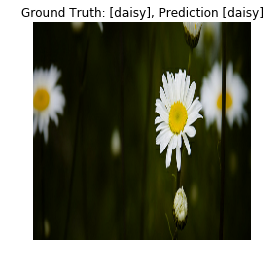

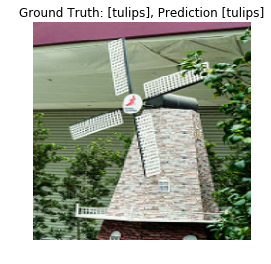

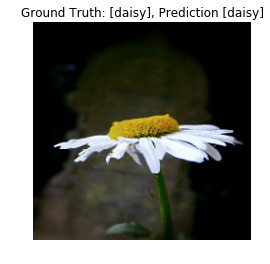

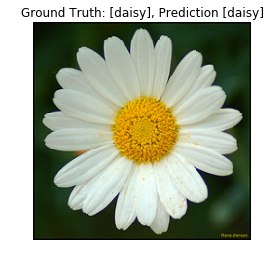

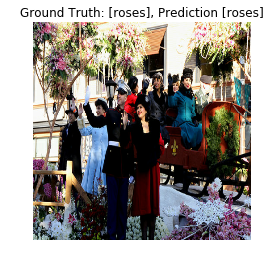

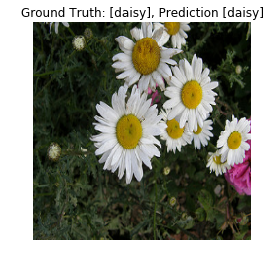

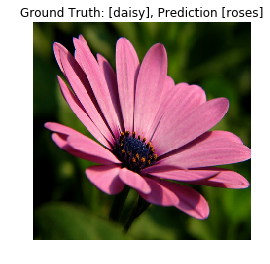

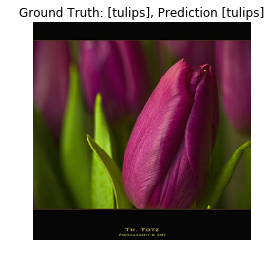

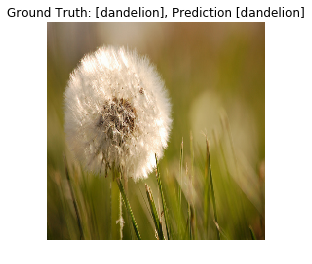

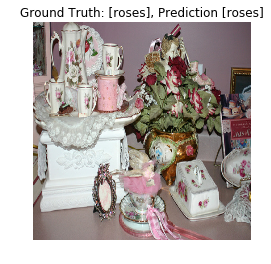

In [19]:
import numpy as np
import tensorflow as tf
from datasets import flowers
from nets import inception

from tensorflow.contrib import slim

image_size = inception.inception_v1.default_image_size
batch_size = 10

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    

    images, images_raw, labels = load_batch(validate_data, num_images = len(filepaths))
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes= len(class_names), is_training=True)

    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
    
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = ids_to_class_name[predicted_label]
                true_name = ids_to_class_name[true_label]
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()

In [20]:
import numpy as np
import tensorflow as tf
from datasets import flowers
from nets import inception

from tensorflow.contrib import slim

image_size = inception.inception_v1.default_image_size
batch_size = 32

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    

    images, images_raw, labels = load_batch(validate_data, num_images = len(filepaths))
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes= len(class_names), is_training=True)

    predictions = tf.argmax(logits, 1, output_type=tf.int32)
    tf_metric, tf_metric_update = tf.metrics.accuracy(labels,
                                                      predictions,
                                                      name="my_metric")
    running_vars = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope="my_metric")

    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            
            for i in range(math.ceil(len(validate_data)/batch_size)):
                sess.run(tf_metric_update)
            
            accuracy = sess.run(tf_metric)
    print(accuracy)
            

INFO:tensorflow:Restoring parameters from ../inception_finetuned/model.ckpt-10000
0.7157738
